In [108]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as pl
import queue
import collections
import seaborn as sns
PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 32                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
recent_frame=0
page_frequencyl={}
page_frequencyg={}
fifo_old_frames={}
mru_recent_frames={}
loc_oldest_frame = np.zeros(F).astype('int32')
phys_mem_fifo_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_fifo_g = np.full((F, 2), INVALID).astype('int32')
phys_mem_lru_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_lru_g = np.full((F, 2), INVALID).astype('int32')
physical_memories=[phys_mem_lru_l,phys_mem_lru_g,phys_mem_fifo_l,phys_mem_fifo_g]
algos=["lrul","lrug","fifol","fifog"]
# ["rr","mru","fifo"]
fifo_l=[]
fifo_g=[]
lru_l=[]
lru_g=[]
faults_list=[lru_l,lru_g,fifo_l,fifo_g]

In [109]:
def init_proc_queue(algo=None):
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        fifo_old_frames[pr]=0
        pq.put_nowait(pr)
    return(pq)

def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [110]:
def init_phys_mem():
    for memory in physical_memories:
        for i in range(F):
            #         initializing Physical memory to implement FIFO
            memory[i, PID] = INVALID
            memory[i, FRAME] = INVALID


def update_phys_mem(pid):
    for memory in physical_memories:
        for i in range(F):
            #         Updating physical memory of FIFO
            if memory[i, PID] == pid:
                memory[i, PID] = INVALID
                memory[i, FRAME] = INVALID

In [111]:
def correct_refs(alist, cent, maxpg):
    if cent != 0:
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else:
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]):
        if alist[i] >= lh:
            alist[i] = lh - 1
        if alist[i] < ll:
            alist[i] = ll + 1
    return alist
def sim_process(M, sigma, outfile,pid, lfrac=0.9):
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  # Locality of reference
    sum_refs = 0
    list_locales = list()
    frequencies={}
    for count in range(M):
        frequencies[cur_page]=0
        # random page address in memory.
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random())
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                     num_loc)  # If siagma is less, it stays less within that locality of reference
        # if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    page_frequency[pid]=frequencies
    return list_locales, sum_refs

In [112]:
def get_oldest_frameL(pr):
    global oldest_frame
    rv = oldest_frame
    oldest_frame += 1
    if oldest_frame == F:
        oldest_frame = 0
    return rv

def get_oldest_frameG(pr):
    global fifo_old_frames
    rv = fifo_old_frames[pr]
    fifo_old_frames[pr] += 1
    if fifo_old_frames[pr] == F:
        fifo_old_frames[pr] = 0
    return rv


def getFifoFrameL(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem_fifo_l[fr_num, PID] == pr and phys_mem_fifo_l[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num

def getFifoFrameG(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem_fifo_g[fr_num, PID] == pr and phys_mem_fifo_g[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLruFrameL(fr_num, pnum, pr):
    global phys_mem_lru_l
    while fr_num < F:
        if phys_mem_lru_l[fr_num, PID] == pr and phys_mem_lru_l[fr_num, FRAME] == pnum:
            temp = phys_mem_lru_l[fr_num]
            phys_mem_lru_l = np.delete(phys_mem_lru_l, fr_num, axis=0)
            phys_mem_lru_l = np.concatenate([phys_mem_lru_l, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num

def getLruFrameG(fr_num, pnum, pr):
    global phys_mem_lru_g
    while fr_num < F:
        if phys_mem_lru_g[fr_num, PID] == pr and phys_mem_lru_g[fr_num, FRAME] == pnum:
            temp = phys_mem[fr_num]
            phys_mem_lru_g = np.delete(phys_mem_lru_g, fr_num, axis=0)
            phys_mem_lru_g = np.concatenate([phys_mem_lru_g, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num



In [113]:
def gen_pagefault(memory,pgnum, pr,algo=None):
    global page_frequencyl
    global page_frequencyg
    fr_num = 0
    while fr_num < F and memory[fr_num, FRAME] >= 0:
        fr_num += 1
    if fr_num >= F:
        return INVALID
    memory[fr_num, FRAME] = pgnum
    memory[fr_num, PID] = pr
    if algo=="lru_l":
        if pgnum not in page_frequency[pr]:
            page_frequencyl[pr][pgnum]=1
        else:
            page_frequencyl[pr][pgnum]+=1
    elif algo=="lru_g":
        if pgnum not in page_frequency:
            page_frequencyg[pgnum]=1
        else:
            page_frequencyg[pgnum]+=1
    return fr_num

In [114]:
def page_replaceLRUL(pgnum, pr):
    global phys_mem_lru_l
    temp = np.array([pr, pgnum])
    try:
        least_used=np.where(phys_mem_lru_l[:,0]==pr)[0][0]
    except:
        least_used=0
    phys_mem_lru_l = np.delete(phys_mem_lru_l, least_used, axis=0)
    phys_mem_lru_l = np.concatenate([phys_mem_lru_l, temp.reshape(1, -1)], axis=0)
    return F-1


def page_replaceFIFOL(pgnum, pr):
    cur_frame = get_oldest_frameL(pr)
    phys_mem_fifo_l[cur_frame, PID] = pr
    phys_mem_fifo_l[cur_frame, FRAME] = pgnum
    return cur_frame

def page_replaceLRUG(pgnum, pr):
    global phys_mem_lru_g
    temp = np.array([pr, pgnum])
    phys_mem_lru_g = np.delete(phys_mem_lru_g, 0, axis=0)
    phys_mem_lru_g = np.concatenate([phys_mem_lru_g, temp.reshape(1, -1)], axis=0)
    return F-1


def page_replaceFIFOG(pgnum, pr):
    cur_frame = get_oldest_frameG(pr)
    phys_mem_fifo_g[cur_frame, PID] = pr
    phys_mem_fifo_g[cur_frame, FRAME] = pgnum
    return cur_frame

#### I used  dict.keys() and dict.values() many places in LFU so as to map and get pages associated to it frequencies and all.

# LeastFreqUsed is divided into two parts. 
1. Geting all the processes that are located in physical memory when page replacement for that particular process
    was called. After that we try to find all the associated pages of particular page and try to find the minimum
    frequency of a page associated to that process. if the page is found with minimum frequency. once the page with 
    minimum frequency is found, we replace that [pid,pgnum] from main memory. if not, it means the physical memory 
    doesnot have current process to replace its associated minimum frequency page.
2. We try to find all other processes and their associated pages which frequency is minimum. once a process and page
    is identified, we replace that with the current pid and page.

In [115]:
def get_pageframe(memory,pnum, pr, algo=None):
    # Trying to get a page Hit below
    fr_num = 0
    if algo == "lrul":
        fr_num = getLruFrameL(fr_num, pnum, pr)
    elif algo == "lrug":
        fr_num = getLruFrameG(fr_num, pnum, pr)
    elif algo == "fifol":
        fr_num = getFifoFrameL(fr_num, pnum, pr)
    elif algo == "fifog":
        fr_num = getFifoFrameG(fr_num, pnum, pr)

    # This indicates Page Hit.
    if fr_num < F:
        return fr_num * PAGE_SIZE, 0

    # This tries to find page fault if occured.
    fr_num = gen_pagefault(memory,pnum, pr,algo)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 1

    # This is for page replacement based on algorith choosen
    if algo == "lrul":
        fr_num = page_replaceLRUL(pnum, pr)
    elif algo == "lrug":
        fr_num = page_replaceLRUG(pnum, pr)
    elif algo == "fifol":
        fr_num = page_replaceFIFOL(pnum, pr)
    elif algo == "fifog":
        fr_num = page_replaceFIFOG(pnum, pr)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

In [116]:
def mem_manager(infile, outfile, pid):
    #    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr:
        addr_ref = infile.readline().strip()
        if addr_ref == '':
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base, pg_fault = get_pageframe(memory,pg_num, pid, algo)
        
        pg_base, pg_fault = get_pageframe(memory,pg_num, pid, algo)
        
        pg_base, pg_fault = get_pageframe(memory,pg_num, pid, algo)
        
        pg_base, pg_fault = get_pageframe(memory,pg_num, pid, algo)
        
        if pg_base >= 0:
            phys_addr = pg_base + pg_offset
            outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault) + '\n')  # Saving the logical add, physical add and faults

            if pg_fault == 0:
                pr_timing[pid] += IN_MEMORY
            elif pg_fault == 1:
                pr_timing[pid] += MEM_FAULT
            else:
                pr_timing[pid] += PAGE_REPLACE

        else:
            print(idx)
            return INVALID
        idx += 1

    if idx >= num_addr:
        return INCOMPLETE
    return COMPLETED

In [117]:
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for memory,algo in zip(physical_memories,algos):
        print(f"--------------------{algo}-------------------------")
        for i in range(F):
            if memory[i, PID] != INVALID:
                print('{:^10d} {:^6d} {:^6d}'.format(i, memory[i, PID],
                                                     memory[i, FRAME]))
            else:
                print('Free Frame: ', i)
    print('_____________________________________________________________')


In [118]:
pr_size = np.zeros(NP, dtype='int32')
def create_simulation():
    for p in range(NP):
        fname = 'AR_' + '{:02d}'.format(p) + '.txt'
        op = open(fname, 'w')
        npg = int(np.random.normal(10, 2.5))
        nsig = int(5 * np.random.random())
        print(f'Process {p} requires {npg} pages and has a quality {nsig}')
        pg_seq, pr_size[p] = sim_process(npg, nsig, op,pid=p)
        print(pg_seq, pr_size[p])
        op.write('\n')
        op.close()
        print('Written process ', p, 'to ', fname)

In [119]:
create_simulation()

Process 0 requires 10 pages and has a quality 1
[7, 2, 8, 1, 3, 2, 3, 4, 5, 1] 15739
Written process  0 to  AR_00.txt
Process 1 requires 8 pages and has a quality 3
[0, 2, 5, 4, 5, 2, 4, 6] 15129
Written process  1 to  AR_01.txt
Process 2 requires 10 pages and has a quality 1
[2, 4, 1, 6, 8, 7, 2, 1, 7, 5] 19830
Written process  2 to  AR_02.txt
Process 3 requires 10 pages and has a quality 4
[9, 2, 7, 1, 3, 2, 8, 5, 7, 6] 26269
Written process  3 to  AR_03.txt
Process 4 requires 14 pages and has a quality 2
[9, 9, 3, 10, 6, 9, 7, 6, 11, 4, 11, 11, 1, 4] 35574
Written process  4 to  AR_04.txt
Process 5 requires 13 pages and has a quality 0
[12, 2, 6, 12, 3, 1, 3, 2, 10, 4, 11, 6, 12] 28226
Written process  5 to  AR_05.txt


In [120]:
# for algo in algos:
#     print(f"_________________________Algorithm {algo}______________________________\n")
#     phys_mem = np.full((F, 2), INVALID).astype('int32')
#     fifo_old_frames={}
#     mru_recent_frames={}
init_phys_mem()
#     oldest_frame = 0
#     recent_frame=0
pr_que = init_proc_queue(algo)
pr_timing = np.zeros(F).astype('int32')
IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100

# Open necessary files
infiles = list()
outfiles = list()
for i in range(NP):
    fname = 'AR_{:02d}.txt'.format(i)
    outname = 'AR_{:02}_{}_out.txt'.format(i, algo)

    if os.access(fname, os.R_OK):
        print(f'Reading Process from {fname}')
        infiles.append(open(fname, 'r'))
    else:
        print(f'Cannot open {fname} for reading')
    outfiles.append(open(outname, 'w'))

# Map logical into physical addresses and keep track of page faults
for pr in readq(pr_que):
    rv = mem_manager(infiles[pr], outfiles[pr], pr)
    if rv == INVALID:
        print('Memory overflow error')
        break
    if rv == INCOMPLETE:
        pr_que.put_nowait(pr)
    else:
#             print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
#             removing from queue')
#             print(f'Time taken: {pr_timing[pr]}')
        slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
        print('Slow down by {:.2f}%'.format(slow))
        print_phys_mem()
        update_phys_mem(pr)

#        print('Current Status of Physical Memory')
#        print_phys_mem()

# Close all files
for i in range(NP):
    infiles[i].close()
    outfiles[i].close()

[5, 0, 2, 3, 4, 1]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
Slow down by 12.26%
  Frame     PID   Page No.
  -----     ---   --------
--------------------lrul-------------------------
    0        5      12  
    1        0      7   
    2        0      7   
    3        0      7   
    4        0      7   
    5        0      7   
    6        0      7   
    7        0      7   
    8        0      7   
    9        0      7   
    10       0      7   
    11       0      7   
    12       0      7   
    13       0      7   
    14       0      7   
    15       0      7   
    16       0      7   
    17       0      7   
    18       0      7   
    19       0      7   
    20       0      7   
    21       0      7   
    22       0      7   
    23       0      7   
    24       0      7   
    25       0      7   
    26       0      7

Slow down by 11.68%
  Frame     PID   Page No.
  -----     ---   --------
--------------------lrul-------------------------
    0        5      12  
    1        4      3   
    2        4      0   
    3        4      2   
    4        4      7   
    5        4      6   
    6        4      10  
    7        4      5   
    8        4      3   
    9        4      6   
    10       4      1   
    11       4      10  
    12       4      7   
    13       4      7   
    14       4      8   
    15       4      3   
    16       4      7   
    17       4      0   
    18       4      2   
    19       4      10  
    20       4      0   
    21       4      5   
    22       4      3   
    23       4      10  
    24       4      5   
    25       4      10  
    26       4      2   
    27       4      0   
    28       4      9   
    29       4      8   
    30       4      6   
    31       4      7   
--------------------lrug-------------------------
    0        5      12  
 

In [122]:
# fig,axes=pl.subplots(2,3,figsize=(15,10))
# axes=axes.ravel()[:5]
# for algo,axs in zip(algos,axes):
#     file_name='AR_00_{}_out.txt'.format(algo)
#     file=open(file_name,'r')
#     data=file.read()
#     datas=np.array(data.split('\n'))
#     faults=[data[-1] for data in datas[:-1]]
#     sns.countplot(x=faults,ax=axs)
#     axs.set_title(" {} {}".format(algo,collections.Counter(faults)))

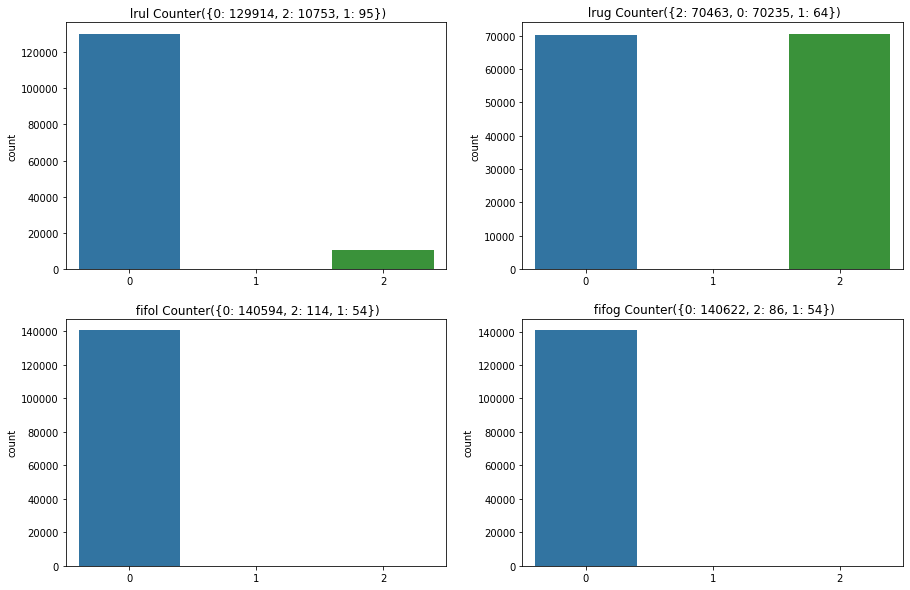

In [130]:
fig,axes=pl.subplots(2,2,figsize=(15,10))
axes=axes.ravel()
for algo,fault,ax in zip(algos,faults_list,axes):
    sns.countplot(x=fault,ax=ax)
    ax.set_title(" {} {}".format(algo,collections.Counter(fault)))
